In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
%matplotlib inline
pio.renderers.default = "plotly_mimetype+notebook_connected"

# Impermanent Loss for Simplified AMM

Asset prices on DEXes can differ from CEXes due to different pricing mechanisms, presenting arbitrage opportunities. Post-arbitrage, the value of the pair held in a DEX pool can be lower than holding it off-chain. The percentage difference is known as "impermanent loss" (IL). We explain and model impermanent loss over a simplified AMM pool. 

## Background

#### Constant Product
DEXes, or decentralized exchanges, do not rely on order books to determine asset prices. Instead the largest DEXes such as Uniswap, Curve are AMMs (automated market makers) that rely on a constant product bonding curve, where two or more tokens are deposited into a pool and the price of each token depends on the ratio of their units denominated in the other. This ratio updates as tokens are swapped and liquidity is deposited/withdrawn.

We plot the bonding curve of a simplified pool with following parameters:
- 5 units of Token A
- 5 units of Token B
- constant product of 25
- no fees 

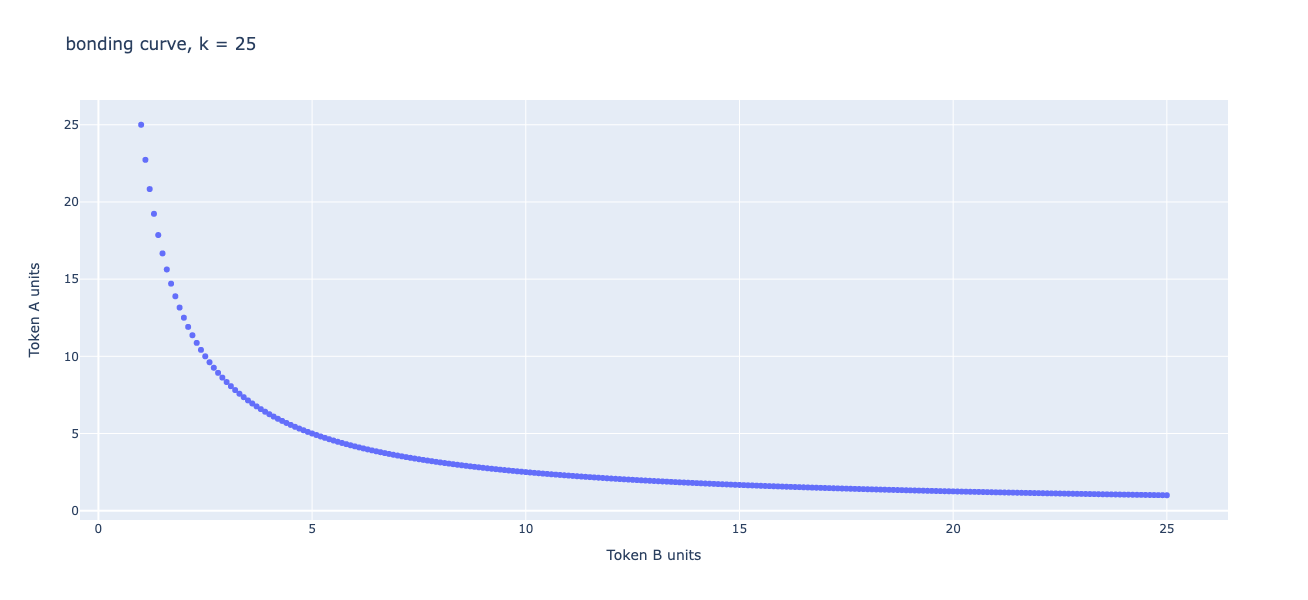

In [2]:
# px.scatter(x=np.geomspace(1,25), y=25/np.geomspace(1,25), title='bonding curve, k = 25')
fig = px.scatter(
    x=np.arange(1,25.1,0.1), 
    y=25/np.arange(1,25.1,0.1), 
    title='bonding curve, k = 25', 
    labels={ 
        "x": "Token B units",  
        "y": "Token A units"
    },
    width=1000, 
    height=600,
)
fig.show()

Starting at 5 units each, by paying 0.1 Token B to swap for Token A, the pool changes to 4.901961 units of Token A to 5.1 units of Token B, giving the user ~0.098 of Token A. As ratio of Token A to Token B decreases, the price of Token A increases relative to Token B, making it marginally more and more expensive for swap Token B for Token A, and cheaper to swap Token A for Token B.

#### CEX / DEX Arbitrage

CEXes, or centralized exchanges, use bid/ask order books to determine asset prices. The difference in pricing mechanisms manifests in the same assets exhibiting different prices on DEXes versus CEXes. Diverging prices on the same asset incentivizes arbitrageurs to swap tokens on AMMs until price converges.  

As price converges due to arbitrage, the underlying value of the AMM pool can be less than holding the same amount of assets off-chain. This is known as "impermanent loss", which is an opportunity cost for the liquidity provider. It is unrealized if the pair remains in the DEX pool hence the characterization of the loss as "impermanent". However this term is misleading given the loss is realized upon withdrawal of liquidity from the pool.

## Model - Single Token IL

We model IL on price change for one token in the pair, keeping the other constant.

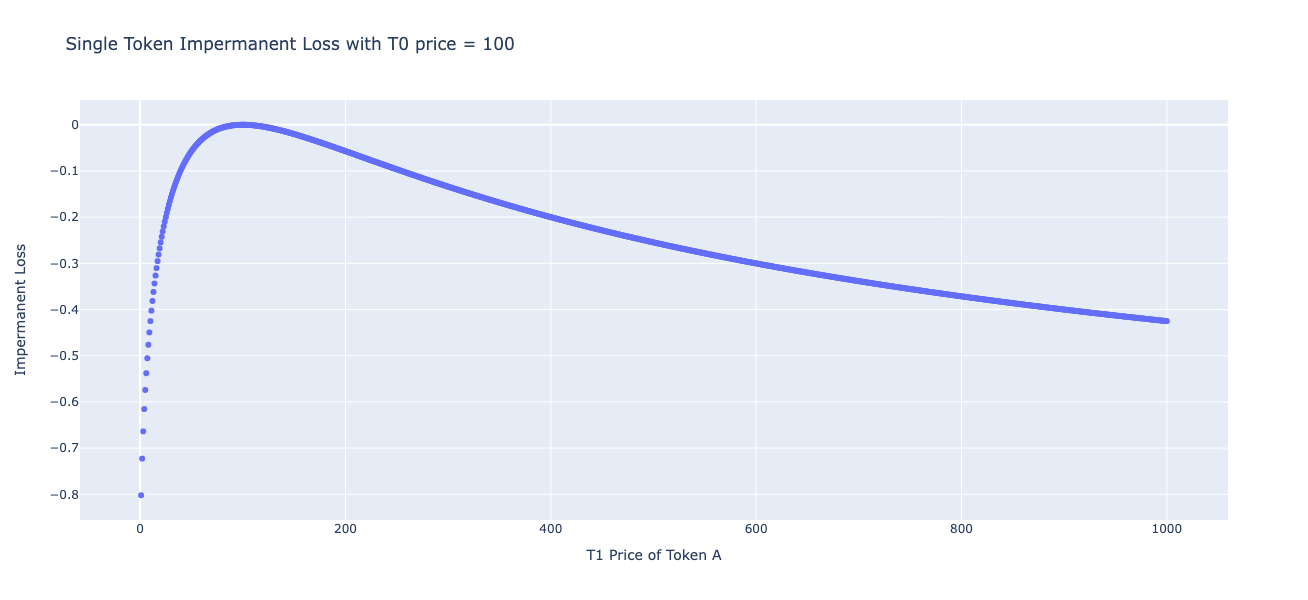

In [3]:
def portValue(a_units, b_units, a_price, b_price):
    a_value = a_units * a_price
    b_value = b_units * b_price
    port_value = a_value + b_value
    return port_value

def impermanentLoss(a_units_t0, b_units_t0, a_price_t0, b_price_t0, price_pct_change):
    # constant product
    invariant = a_units_t0 * b_units_t0    
    # T1 price
    a_price_t1 = a_price_t0 * (1+price_pct_change)
    b_price_t1 = b_price_t0
    # see appendix/table for derivation
    a_units_t1 = np.sqrt(invariant/(a_price_t1/b_price_t1))
    b_units_t1 = np.sqrt(invariant/(b_price_t1/a_price_t1))
    # portfolio value at t0
    port_pool_t0 = portValue(a_units_t0, b_units_t0, a_price_t0, b_price_t0)
    port_hold_t0 = port_pool_t0
    # portfolio value at t1
    port_pool_t1 = portValue(a_units_t1, b_units_t1, a_price_t1, b_price_t1)
    port_hold_t1 = portValue(a_units_t0, b_units_t0, a_price_t1, b_price_t1)
    # returns
    port_pool_ret = port_pool_t1/port_pool_t0 - 1
    port_hold_ret = port_hold_t1/port_hold_t0 - 1
    # impermanent loss
    il = port_pool_t1/port_hold_t1 - 1
    
    # return a_units_t1, b_units_t1, port_pool_ret, port_hold_ret, il
    return il

il_list_single = []
for price_pct_change in (np.arange(-0.99,9.01,0.01)):
    il_list_single.append(
        impermanentLoss(
            0.1, #a_units_t0 
            10, #b_units_t0 
            100, #a_price_t0 
            1, #b_price_t0 
            price_pct_change
        )
    )

fig = px.scatter(
    # price of Token A
    x=100*(np.arange(-0.99,9.01,0.01))+100, 
    # impermanent loss
    y=il_list_single,
    title=f'Single Token Impermanent Loss with T0 price = 100',
    labels={ 
        "x": "T1 Price of Token A",  
        "y": "Impermanent Loss"
    },
    # width=1400, 
    height=600,
)
fig.show()

Impermanent loss occurs when price of one token in the pair moves in **either direction**. For example, by 1.25x the price of Token A, the impermanent loss is -0.6%. At 0.75x price, the loss is roughly -1%. The rate of loss is higher when token price decreases than when it increases.  

| 25% price change     | A                                                    | B                                             |
|----------------------|------------------------------------------------------|-----------------------------------------------|
| **t0**               |                                                      |                                               |
| units                | 0.1                                                  | 10                                            |
| invariant            | A units * B units = 1                                | A units * B units = 1                         |
| ratio                | B units / A units = 100                              | A units / B units = 0.01                      |
| CEX price            | 100                                                  | 1                                             |
| DEX price            | A ratio * B CEX price = 100                          | B ratio * A CEX price = 1                     |
| value actual         | A units * A CEX price = 10                           | B units * B CEX price = 10                    |
| value offer          | A units * A DEX price = 10                           | B units * B DEX price = 10                    |
| **t1**               |                                                      |                                               |
| CEX price            | 125 (x0.25)                                          | 1 (no change)                                 |
| DEX arb price        | 125 = A ratio * 1                                    | 1 = B ratio * 125                             |
| ratio                | 125/1 = B units / A units                            | 1/125 = A units / B units                     |
| invariant            | 1 = 125 * A units^2                                  | 1 = (1/125) * B units^2                       |
| units                | A units = sqrt(1/125) = 0.089                        | B units = sqrt(1/(1/125)) = 11.18             |
| value hold           | A units (t0) * A CEX price (t1) = 0.1*125 = 12.5     | B units (t0) * B CEX price (t1) = 10*1 = 10   |
| value pool           | A units (t1) * A CEX price (t1) = 0.089*125 = 11.18  | B units (t1) * B CEX price (t1) = 11.18*1 = 11.18 |

| Impermanent Loss     |                                                     |
|----------------------|------------------------------------------------------|
| Hold Portfolio       | A value hold + B value hold = 12.5 + 10 = 22.5           |
| LP Portfolio         | A value pool + B value pool = 11.18 + 11.18 = 22.36      |
| Loss                 | LP Portfolio / Hold Portfolio - 1 = 22.36/22.5-1 = **-0.6%**   |

## Model - Double Token IL

We model a special instance of double token IL, where price of Token A and B decreases/increases by the same percent change. For example, the price of both tokens at T0 is 100, and with 25% change, token A will be worth 75 and token B 125 at T1.  

Intuitively, a portfolio holding A/B should not change value in this case. However, though that is true for holding (off-chain) portfolio, the DEX pool still incurs IL.

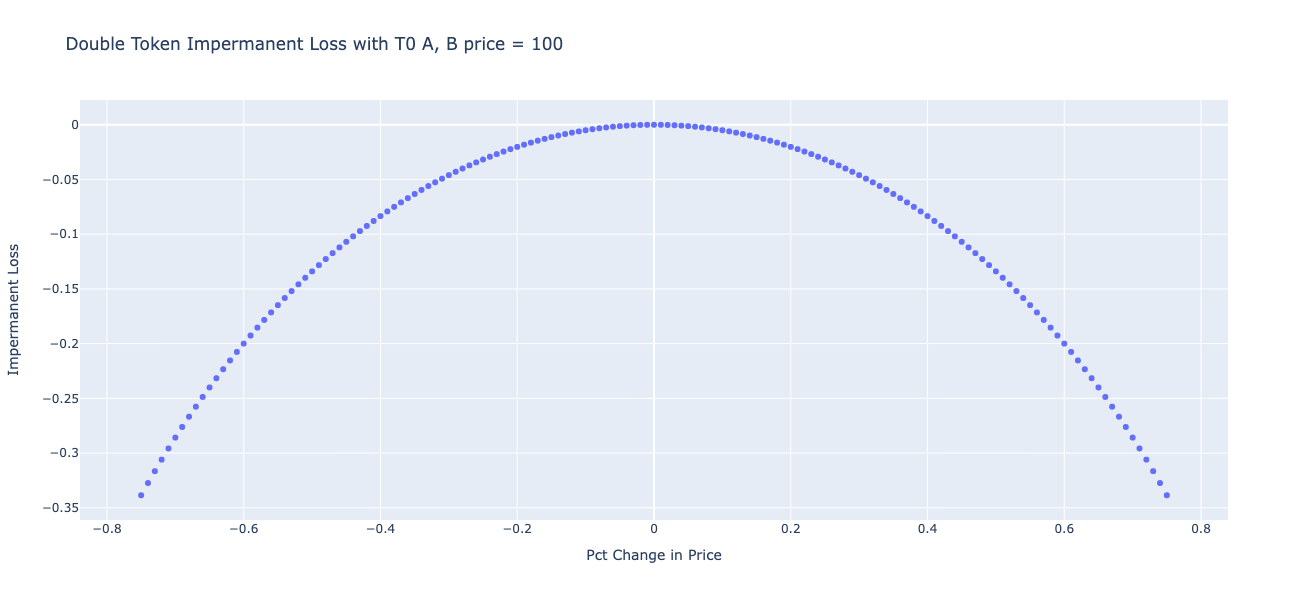

In [4]:
def impermanentLossDouble(a_units_t0, b_units_t0, a_price_t0, b_price_t0, price_pct_change):
    # constant product
    invariant = a_units_t0 * b_units_t0    
    # T1 price
    a_price_t1 = a_price_t0 * (1-price_pct_change)
    b_price_t1 = b_price_t0 * (1+price_pct_change)
    # see appendix/table for derivation
    a_units_t1 = np.sqrt(invariant/(a_price_t1/b_price_t1))
    b_units_t1 = np.sqrt(invariant/(b_price_t1/a_price_t1))
    # portfolio value at t0
    port_pool_t0 = portValue(a_units_t0, b_units_t0, a_price_t0, b_price_t0)
    port_hold_t0 = port_pool_t0
    # portfolio value at t1
    port_pool_t1 = portValue(a_units_t1, b_units_t1, a_price_t1, b_price_t1)
    port_hold_t1 = portValue(a_units_t0, b_units_t0, a_price_t1, b_price_t1)
    # returns
    port_pool_ret = port_pool_t1/port_pool_t0 - 1
    port_hold_ret = port_hold_t1/port_hold_t0 - 1
    # impermanent loss
    il = port_pool_t1/port_hold_t1 - 1
    return il

il_list_double = []
for price_pct_change in (np.arange(-0.75,0.76,0.01)[::-1]):
    il_list_double.append(
        impermanentLossDouble(
            0.5, #a_units_t0 
            0.5, #b_units_t0 
            100, #a_price_t0 
            100, #b_price_t0 
            price_pct_change
        )
    )

fig = px.scatter(
    x=(np.arange(-0.75,0.76,0.01)[::-1]), 
    y=il_list_double,
    title=f'Double Token Impermanent Loss with T0 A, B price = 100',
    labels={ 
        "x": "Pct Change in Price",  
        "y": "Impermanent Loss"
    },
    # width=1400, 
    height=600,
)
fig.show()

With +/- 25% change for price for Token A and B, the IL is roughly -3.2%. At +/- 75% change, the IL is roughly -34%.

The greater the divergence of price to CEX and between tokens, the greater the IL.

| +/- 25% price change   | A                                                       | B                                                   |
|------------------------|---------------------------------------------------------|-----------------------------------------------------|
| **t0**                 |                                                         |                                                     |
| units                  | 0.5                                                     | 0.5                                                 |
| invariant              | A units * B units = 0.25                                | A units * B units = 0.25                            |
| ratio                  | B units / A units = 1                                   | A units / B units = 1                               |
| CEX price              | 100                                                     | 100                                                 |
| DEX price              | A ratio * B CEX price = 100                             | B ratio * A CEX price = 1                           |
| value actual           | A units * A CEX price = 50                              | B units * B CEX price = 50                          |
| value offer            | A units * A DEX price = 50                              | B units * B DEX price = 50                          |
| **t1**                 |                                                         |                                                     |
| CEX price              | 75 (-25%)                                               | 125 (+25%)                                          |
| DEX arb price          | 75 = A ratio * 125                                      | 125 = B ratio * 75                                  |
| ratio                  | 75/125 = B units / A units                              | 125/75 = A units / B units                          |
| invariant              | 0.25 = (75/125) * A units^2                             | 0.25 = (125/75) * B units^2                         |
| units                  | A units = sqrt(0.25/(75/125)) = 0.65                    | B units = sqrt(1/(1/400)) = 0.39                    |
| value hold             | A units (t0) * A CEX price (t1) = 0.5*75 = 37.5         | B units (t0) * B CEX price (t1) = 0.5*125 = 62.5    |
| value pool             | A units (t1) * A CEX price (t1) = 0.65*75 = 48.375      | B units (t1) * B CEX price (t1) = 0.39*125 = 48.375|

| Impermanent Loss       |                                                         |
| ---------------------- | ------------------------------------------------------  |
| Hold Portfolio         | A value hold + B value hold = 37.5 + 62.5 = 100         |
| LP Portfolio           | A value pool + B value pool = 48.375 + 48.375 = 96.75     |
| Loss                   | LP Portfolio / Hold Portfolio - 1 = 96.82/100-1 = **-3.2%** |

## Discussion

Impermanent loss occurs at any time when price changes in either direction, even when delta percent change of both tokens sum to 0. The extent of IL varies, suggesting different approaches to risk management and hedging depending on pool parameters. 


For example, IL increases more sharply when single token price decreases than when it increases, suggesting more protection against downside risk of token/stablecoin pools. For token/token pools, bidirecitonal perp hedging is warranted, with exponentially stronger positions against higher price changes.

#### Hedges against IL
1. **Trading fees:** For sufficiently small price changes, IL can be lower than trading fees. This is a natural hedge against IL built into the protocol's tokenomics / revenue sharing. Further, some protocols like Uniswap V3 allows LPs to restrict their liquidity to within price change thresholds, making it easier to manage (although requiring more active monitoring.)
2. **(Boosted) rewards:** For situations where IL can be often higher than trading fees e.g. especially volatile tokens, some protocols offer boosted rewards through a second-order liquidity incentive not for underlying tokens but for the LP tokens. For example, Curve LPs can lock their LP tokens in exchange for veCRV tokens which can be used to vote for pools to receive boosted rewards. The longer the lock-in for LP tokens, the greater the amount of veCRV received. This "flywheel" effect depends on high inflation and higher demand, which has its own risks associated.
3. **Perpetuals:** Similiar in TradFi, volatility can be traded with perpetuals. For example, for token/stablecoin pools, emphasize stronger position on downside (short perps) given greater IL than upside. 

## To Do

- introduce more parameters to model (safe math, fees)
- historical IL for protocols/pools --> curious reln between IL, volatility, liquidity, revenue
- % IL covered by trading fees, boosted rewards per protocol/pool
- backtest perp strategy (hunch: buy cheap puts, sell calls)

## Appendix

### Terminology 


for A/B pool on Ethereum:  
A units = amount of token A in wei in pool  
B units = amount of token B in wei in pool  
invariant = A units * B units (constant product)  

A ratio = B units / A units  
B ratio = A units / B units  

A price CEX = price of A on a CEX  
B price CEX = price of B on a CEX  

A price DEX = A ratio * B price CEX  
B price DEX = B ratio * A price CEX  

A value = A units * A price  
B value = B units * B price  
total_liquidity = A value + B value  

IL/Arbitrage when price CEX =/= price DEX.  

### Single Token IL (token/stablecoin pair)

A = Token  
B = Stablecoin (denominated)  

t0:  
A units (t0) = 0.1  
B units (t0) = 10  
invariant (t0) = A units (t0) * B units (t0) = 0.1*10 = 1  

A ratio (t0) = B units (t0) / A units (t0) = 10/0.1 = 100  
B ratio (t0) = A units (t0) / B units (t0) = 0.1/10 = 0.01  

A price CEX (t0) = 100  
B price CEX (t0) = 1  

A price DEX (t0) = A ratio (t0) * B price CEX (t0) = 100*1 = 100  
B price DEX (t0) = B ratio (t0) * A price CEX (t0) = 0.01*100 = 1  

t1:  
A price CEX (t1) = 400 (+300)  
B price CEX (t1) = 1 (no change)  

A value actual (t1 pre-arb) = A units (t0) * A price CEX (t1) = 0.1*400 = 40  
B value actual (t1 pre-arb) = B units (t0) * B price CEX (t1) = 10*1 = 10  

A value actual (t1 pre-arb) > A value offered (t0) --> arbitrage  

*Solve for A units (t1) and B units (t1)*  

A ratio (t1) * B price CEX (t1) = A price CEX (t1)  
(B units (t1) / A units (t1)) * B price CEX (t1) = A price CEX (t1)   
(B units (t1) / A units (t1)) * 1 = 400  
[1] B units (t1) = 400 * A units (t1)  

invariant (t1) = invariant (t0) = A units (t1) * B units (t1)  
[2] 1 = A units (t1) * B units (t1)  

Sub [1] into [2]:  
1 = A units (t1) * (400 * A units (t1))  
A units (t1) = sqrt(1/400) = 0.05  
B units (t1) = 1 / 0.05 = 20  

portfolio - post-arbitrage DEX:  
A value pool (t1) = A units (t1) * A price CEX (t1) = 0.05*400 = 20  
B value pool (t1) = B units (t1) * B price CEX (t1) = 20*1 = 20  
total_liquidity = A value (t1) + B value (t1) = 20+20 = 40  


holding in CEX:  
A value hold (t1) = A units (t0) * A price (t1) = 0.1*40 = 40  
B value hold (t1) = B units (t0) * B price (t1) = 10*1 = 10  
total_liquidity = A value (t1) + B value (t1) = 50  

impermanence loss = (portfolio/holding)-1 = (40/50)-1 = -20%  

### Double Token IL (token/token pair)

A = TokenA
B = TokenB

t0:
A units (t0) = 0.5  
B units (t0) = 0.5  
A ratio (t0) = B units (t0) / A units (t0) = 0.5/0.5 = 1  
B ratio (t0) = A units (t0) / B units (t0) = 0.5/0.5 = 1  
A price (t0) = 100  
B price (t0) = 100  
A value (t0) = A ratio (t0) * B price (t0)  
B value (t0) = B ratio (t0) * A price (t0)  
total_liquidity (t0) = A value (t0) + B value (t0) = 100  
invariant (t0) = A units (t0) * B units (t0) = 0.5*0.5 = 0.25  

t1:
A price (t1) = 75
B price (t1) = 125

*Solve for A units (t1) and B units (t1)*

A ratio (t1) * B price (t1) = A price (t1)  
(B units (t1) / A units (t1)) * B price (t1) = A price (t1)   
(B units (t1) / A units (t1)) * 125 = 75  
[1] B units (t1) = (75/125) * A units (t1)  

invariant (t1) = invariant (t0) = A units (t1) * B units (t1)  
[2] 0.25 = A units (t1) * B units (t1)  

Sub [1] into [2]:  
0.25 = A units (t1) * ((75/125) * A units (t1))  
A units (t1) = sqrt(1/(75/125)) = 0.645  
B units (t1) = 0.25 / 0.645 = 0.387  

portfolio post-arbitrage DEX:  
A value pool (t1) = A units (t1) * A price CEX (t1) = 0.645*75 = 48.375.   
B value pool (t1) = B units (t1) * B price CEX (t1) = 0.387*125 = 48.375  
total_liquidity = A value (t1) + B value (t1) = 20+20 = 96.75  

holding in CEX:  
A value hold (t1) = A units (t0) * A price (t1) = 0.5*75 = 37.5    
B value hold (t1) = B units (t0) * B price (t1) = 0.5*125 = 62.5   
total_liquidity = A value (t1) + B value (t1) = 100  

impermanence loss = (portfolio/holding)-1 = (96.75/100)-1 = -3.25% 